In [23]:
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
import time
from PIL import Image
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

# Images Preprocessing

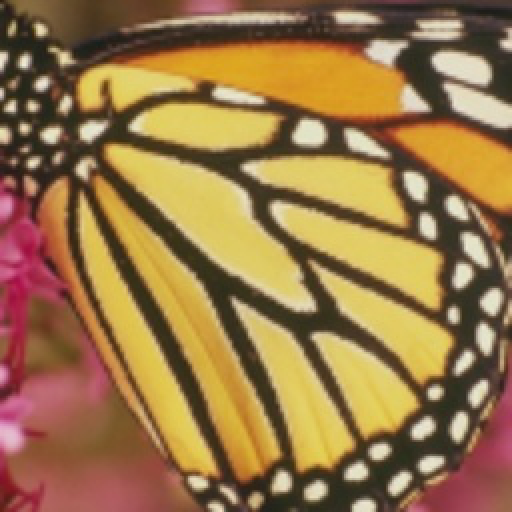

In [25]:
height = 512
width = 512

content_image = Image.open('lake.jpg')
content_image = content_image.resize((height,width))
content_image
#^Image for the base template

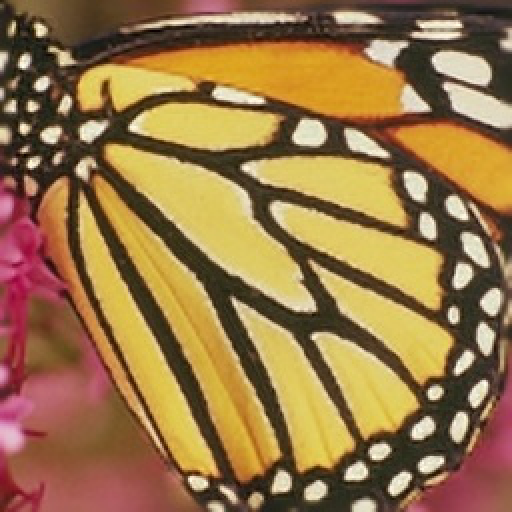

In [26]:
style_image = Image.open('monet.jpg')
style_image = style_image.resize((height,width))
style_image
#^ Image to give the style template

In [27]:
content_array = np.asarray(content_image, dtype='float32')
content_array.shape
#^Convert Image to numerical data

(512, 512, 3)

In [28]:
content_array = np.expand_dims(content_array, axis=0)
content_array.shape
#^Incresing one dimension dimension

(1, 512, 512, 3)

In [29]:
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
style_array.shape
#^Converting style image to numerical data then adding one feature similar to content image

(1, 512, 512, 3)

In [30]:
content_array[:,:,:,0] -= 103.939 # mean of R component
content_array[:,:,:,1] -= 116.779 # mean of G component
content_array[:,:,:,2] -= 123.68  # mean of blue component
content_array = content_array[:,:,:,::-1] 
#^Subtracting RGB mean

In [31]:
style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array = style_array[:,:,:,::-1]
#^ Reversing the order of RGB as BGR

# VGG 16 model using imagenet predefined model's weights

In [32]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,height,width,3))
#^ Preparing imgaes for VGG 16

In [33]:
input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)

In [34]:
input_tensor

<tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>

In [35]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [36]:
model.summary()
#^ Outputting model's layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [37]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers
#^ Descriptoin of layers (every block has been divided into CNNs and a final max pooling layer)

{'input_2': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

In [38]:
layers['block2_conv2'][0,:,:,:]

<tf.Tensor 'strided_slice:0' shape=(256, 256, 128) dtype=float32>

In [39]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
#^ Using 3 hyperparameters for losses of content (loss in base image), style(loss in style image) and variation loss

In [40]:
loss = backend.variable(0.)
#^ Initialising loss

# Content Loss

In [41]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features, combination_features)

In [42]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
#^ defining gram matrix

# Style Loss

In [43]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

# The Total Variation Loss

In [44]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)


# Loss Optimization

In [45]:
grads = backend.gradients(loss, combination_image)

In [46]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

epochs = 10

for i in range(epochs):
    print('Starting epoch', i, end = "; ")
    s_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    f_time = time.time()
    print('epoch %d completed in %ds' % (i, f_time - s_time))

Starting epoch 0; 

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

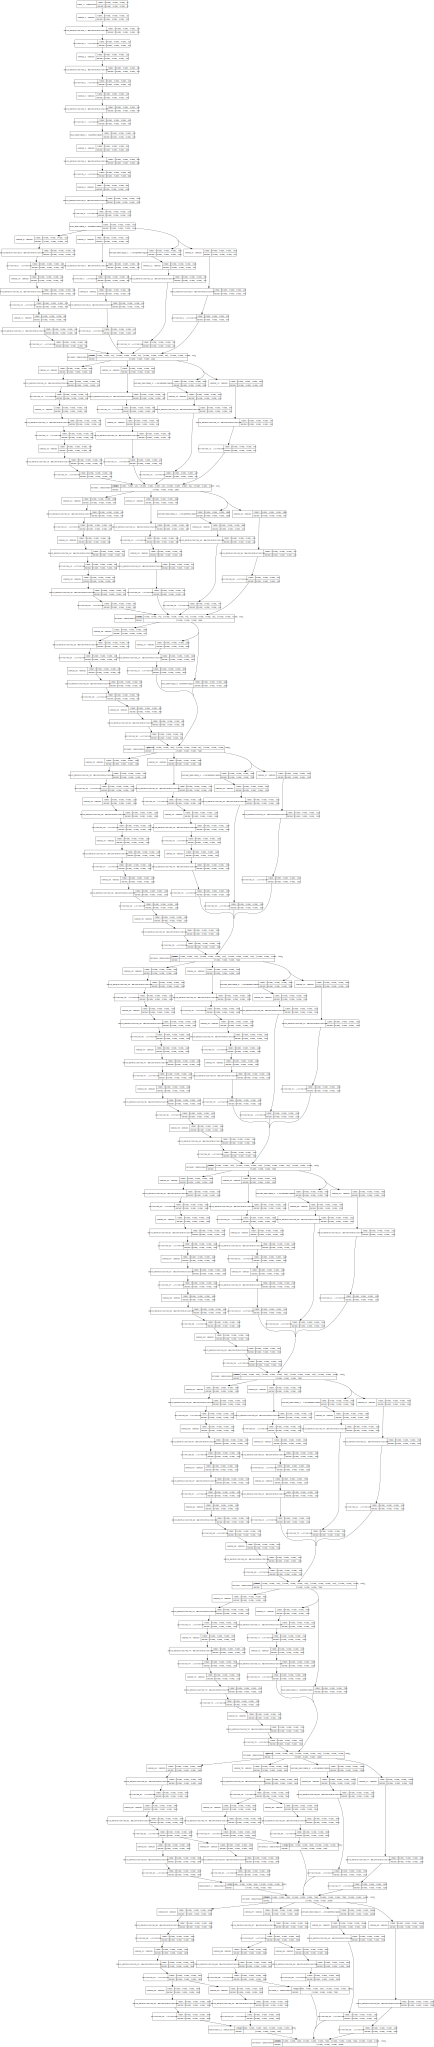

In [5]:
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
from keras.utils import plot_model

In [10]:
plot_model(base_model, to_file='ORIGINAL INCEPTION.png')

In [8]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
plot_model(model, to_file='MODIFIED INCEPTION.png')

In [13]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [15]:
import numpy as np

In [17]:
data = np.load('train.npy')
labels = np.load('tlabels.npy')

In [18]:
model.fit(data, labels, batch_size=25, epochs=10, verbose=1, callbacks=None, validation_split=0.3, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)

Train on 35 samples, validate on 15 samples
Epoch 1/10
35/35 [==============================] - 18s 506ms/step - loss: 1.3377 - val_loss: 5.3727
Epoch 2/10
35/35 [==============================] - 11s 317ms/step - loss: 6.6999 - val_loss: 3.7814
Epoch 3/10
35/35 [==============================] - 11s 308ms/step - loss: 1.3874 - val_loss: 10.7454
Epoch 4/10
35/35 [==============================] - 12s 343ms/step - loss: 2.9043 - val_loss: 5.3727
Epoch 5/10
35/35 [==============================] - 11s 320ms/step - loss: 1.3417 - val_loss: 5.3727
Epoch 6/10
35/35 [==============================] - 11s 313ms/step - loss: 0.9884 - val_loss: 5.3727
Epoch 7/10
35/35 [==============================] - 11s 311ms/step - loss: 0.1703 - val_loss: 5.3727
Epoch 8/10
35/35 [==============================] - 11s 315ms/step - loss: 0.1672 - val_loss: 5.3727
Epoch 9/10
35/35 [==============================] - 11s 310ms/step - loss: 0.1202 - val_loss: 5.3727
Epoch 10/10
35/35 [===========================

In [19]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [20]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

In [21]:
model.fit(data, labels, batch_size=25, epochs=10, verbose=1, callbacks=None, validation_split=0.3, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)

Train on 35 samples, validate on 15 samples
Epoch 1/10
35/35 [==============================] - 27s 769ms/step - loss: 1.5330 - val_loss: 10.7454
Epoch 2/10
35/35 [==============================] - 22s 621ms/step - loss: 1.7887 - val_loss: 10.7454
Epoch 3/10
35/35 [==============================] - 13s 382ms/step - loss: 1.4968 - val_loss: 10.7454
Epoch 4/10
35/35 [==============================] - 13s 382ms/step - loss: 1.3804 - val_loss: 10.7454
Epoch 5/10
35/35 [==============================] - 16s 462ms/step - loss: 1.2567 - val_loss: 10.7454
Epoch 6/10
35/35 [==============================] - 14s 394ms/step - loss: 1.0867 - val_loss: 10.7454
Epoch 7/10
35/35 [==============================] - 13s 381ms/step - loss: 0.9792 - val_loss: 10.7454
Epoch 8/10
35/35 [==============================] - 13s 383ms/step - loss: 0.9338 - val_loss: 10.7454
Epoch 9/10
35/35 [==============================] - 13s 379ms/step - loss: 0.5282 - val_loss: 10.7454
Epoch 10/10
35/35 [===================